In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.feature_selection import RFECV

In [3]:
import xgboost
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import weight_of_evidence, utils

In [6]:
import importlib
importlib.reload(weight_of_evidence)
importlib.reload(utils)

<module 'utils' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/utils.py'>

In [7]:
data = pd.read_csv('~/Downloads/application_train.csv')

In [8]:
EXCLUDE_COLS = ['SK_ID_CURR','TARGET',"ORGANIZATION_TYPE"]

In [9]:
CATERORICAL_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes('O').columns

In [10]:
NUMERIC_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes('int64').columns

In [11]:
data[CATERORICAL_COLS] = data[CATERORICAL_COLS].fillna('MISSING')

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [13]:
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATERORICAL_COLS),
    ]
)

In [14]:
log_reg_cv = LogisticRegressionCV(penalty='l2', solver='lbfgs',max_iter=1e6,cv=3)

In [15]:
log_reg = LogisticRegression(solver='lbfgs',max_iter=1e6)

In [16]:
ohe_logit = Pipeline(steps=[
    ('preprocessor', ohe_preprocessor),
    ('log_reg_classifier',log_reg ),
])

In [19]:
ohe_lgb = Pipeline(steps=[('preprocessor', ohe_preprocessor),
                      ('lgb_classifier', lgb.LGBMClassifier())
                         ]
                  )


In [21]:
combined_results = pd.DataFrame()

In [22]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)

In [23]:
X = data.drop(columns=EXCLUDE_COLS)
y = data.TARGET

In [26]:
def get_cv_results(X, y, cv, clf, model_name):
    results = {'auc':[],'fold':[]}
    fold = 1
    for train, test in cv.split(X,y):
        print(f'fold {fold}')
        prediction = clf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        auc = roc_auc_score(y_true=y.iloc[test], y_score=prediction[:,1])
        results['auc'].append(auc)
        results['fold'].append(fold)
        print(f'auc {auc}')
        fold +=1
    results_df=pd.DataFrame(results)
    results_df['model'] = model_name
    return results_df
    

In [25]:
combined_results = get_cv_results(X,y,cv,ohe_logit,'ohe logit' )

fold 1
auc 0.6669423842307379
fold 2
auc 0.6692845318470961
fold 3
auc 0.6607980219033633
fold 4
auc 0.6643616125265204
fold 5
auc 0.6708302119648548


In [27]:
combined_results.groupby('model')[['auc']].mean()

,auc
model,
ohe logit,0.666443


In [28]:
combined_results = combined_results.append(get_cv_results(X,y,cv,ohe_lgb,'ohe lgbm' ))

fold 1
auc 0.6718458585028875
fold 2
auc 0.674299292742745
fold 3
auc 0.6613001607855444
fold 4
auc 0.6673642590123721
fold 5
auc 0.6726818240444667


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [29]:
combined_results.groupby('model')[['auc']].mean()

,auc
model,
ohe lgbm,0.669498
ohe logit,0.666443


In [30]:
woebin_logit = Pipeline(
        steps=[
            ("tree_bin", weight_of_evidence.TreeBinner()),
            ("woe_scale", weight_of_evidence.WoeScaler()),
            ("standard_scale", StandardScaler()),
            ('log_reg_classifier',log_reg ),
        ]
    )


In [31]:
combined_results = combined_results.append(get_cv_results(X,
                                                          y,
                                                          cv,
                                                          woebin_logit,
                                                          'woe regression' ))

fold 1
auc 0.7316678687919687
fold 2
auc 0.7338198936500174
fold 3
auc 0.7391384597287401
fold 4
auc 0.739507076446707
fold 5
auc 0.7364763739369423


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [32]:
combined_results.groupby('model')[['auc']].mean()

,auc
model,
ohe lgbm,0.669498
ohe logit,0.666443
woe regression,0.736122


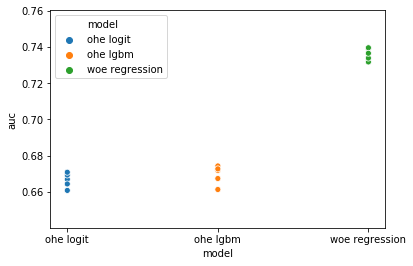

In [33]:
sns.scatterplot(data=combined_results,x='model',y='auc',hue='model')

In [34]:
'''rfe = RFECV(estimator=woebin_logit, 
            step=1, min_features_to_select=1, cv=cv)'''

'rfe = RFECV(estimator=woebin_logit, \n            step=1, min_features_to_select=1, cv=cv)'

In [35]:
woebin_logit.fit(X,y)

Pipeline(memory=None,
         steps=[('tree_bin', TreeBinner()),
                ('woe_scale', WoeScaler(clip_thresh=100000.0)),
                ('standard_scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg_classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000000.0,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

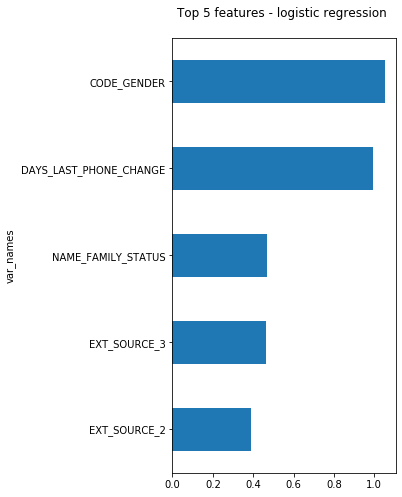

In [36]:
var_importance = utils.plot_reg_coefs(X.columns, 
                     woebin_logit['log_reg_classifier'].coef_[0],n=5)

In [37]:
top_8 = var_importance.tail(8).var_names

In [ ]:
weight_of_evidence.plot_bins(X,y,t,woebin_logit['tree_bin'].splits_)